# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment


# Load Reacher env with 20 agents
# env = UnityEnvironment(file_name='Reacher')
env = UnityEnvironment(file_name='/home/arasdar/unity-envs/Reacher_Linux_NoVis_MultiAgents/Reacher_Linux_NoVis/Reacher.x86_64')

ModuleNotFoundError: No module named 'unityagents'

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


### 3. Instantiate DDPG Agent

In [4]:
from agent import Agent

random_seed = 7

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [5]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
n_steps=1000
n_learn=10
learn_every=20
R_goal=30 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot
meanRs_deque = [] # plot
glosses, dlosses = [], []

In [ ]:
for i_episode in range(n_episodes):
    
    # Reset Env and Agent
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment (env)    
    S = env_info.vector_observations                   # get the current states (S) (for all agents)

    Rs = np.zeros(num_agents)                            # initialize the total scores (Rs) (for all agents)
    gloss__, dloss__ = [], []

    for i_step in range(n_steps):
        
        A = agent.act(S) # A: actions [-1, +1], S: current states for all agents
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        env_info = env.step(A)[brain_name]            # send all actions (A) to the environment (env)
        S2 = env_info.vector_observations          # get next states (S) (for all agents)
        rewards = env_info.rewards                          # get rewards (for all agents)

        dones = env_info.local_done                         # see if episode is done/finished (terminal) for all agents

        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        for s, a, r, s2, done in zip(S, A, rewards, S2, dones):
            agent.step(s, a, r, s2, done) # send an exprience (e) to the agent or collecting experiences (E)

        Rs += rewards                           # update the total scores (for all agents)
        S = S2                                # roll over states (S) to next states (S2)

        gloss_, dloss_ = [], []
        if i_step%learn_every == 0:
            for _ in range(n_learn):
                dloss, gloss = agent.start_learn()
                #print('dloss, gloss:', dloss, gloss)
                dloss_.append(dloss)
                gloss_.append(gloss)
                
            dloss__.append(np.mean(dloss_))
            gloss__.append(np.mean(gloss_))

        if np.any(dones):                                   # exit loop if episode is done/finished for any of the agents among all of them
            break

    meanR = np.mean(Rs)
    Rs_deque.append(meanR)
    meanRs.append(meanR) # plot
    meanRs_deque.append(np.mean(Rs_deque)) # plot
    dlosses.append(np.mean(dloss__))
    glosses.append(np.mean(gloss__))

    print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode+1, np.mean(Rs_deque)), 
          'Gloss {:.2f}, Dloss {:.2f}'.format(gloss, dloss))
    
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-reacher-multiple.pth')
        torch.save(agent.d.state_dict(), 'd-reacher-multiple.pth')
        break

Episode 1	Total Average Score: 0.08 Gloss 0.03, Dloss 0.00
Episode 2	Total Average Score: 0.04 Gloss 0.03, Dloss 0.00
Episode 3	Total Average Score: 0.03 Gloss 0.03, Dloss 0.00
Episode 4	Total Average Score: 0.04 Gloss 0.03, Dloss 0.00
Episode 5	Total Average Score: 0.05 Gloss 0.03, Dloss 0.00
Episode 6	Total Average Score: 0.05 Gloss 0.03, Dloss 0.00
Episode 7	Total Average Score: 0.05 Gloss 0.03, Dloss 0.00
Episode 8	Total Average Score: 0.05 Gloss 0.02, Dloss 0.00
Episode 9	Total Average Score: 0.04 Gloss 0.02, Dloss 0.00
Episode 10	Total Average Score: 0.05 Gloss 0.02, Dloss 0.00
Episode 11	Total Average Score: 0.04 Gloss 0.02, Dloss 0.00
Episode 12	Total Average Score: 0.04 Gloss 0.02, Dloss 0.00
Episode 13	Total Average Score: 0.04 Gloss 0.02, Dloss 0.00
Episode 14	Total Average Score: 0.03 Gloss 0.02, Dloss 0.00
Episode 15	Total Average Score: 0.03 Gloss 0.02, Dloss 0.00
Episode 16	Total Average Score: 0.03 Gloss 0.02, Dloss 0.00
Episode 17	Total Average Score: 0.03 Gloss 0.01, 

Episode 136	Total Average Score: 0.80 Gloss -0.08, Dloss 0.00
Episode 137	Total Average Score: 0.80 Gloss -0.08, Dloss 0.00
Episode 138	Total Average Score: 0.80 Gloss -0.08, Dloss 0.00
Episode 139	Total Average Score: 0.81 Gloss -0.08, Dloss 0.00
Episode 140	Total Average Score: 0.81 Gloss -0.08, Dloss 0.00
Episode 141	Total Average Score: 0.81 Gloss -0.08, Dloss 0.00
Episode 142	Total Average Score: 0.81 Gloss -0.08, Dloss 0.00
Episode 143	Total Average Score: 0.82 Gloss -0.08, Dloss 0.00
Episode 144	Total Average Score: 0.82 Gloss -0.08, Dloss 0.00
Episode 145	Total Average Score: 0.82 Gloss -0.08, Dloss 0.00
Episode 146	Total Average Score: 0.83 Gloss -0.08, Dloss 0.00
Episode 147	Total Average Score: 0.83 Gloss -0.08, Dloss 0.00
Episode 148	Total Average Score: 0.83 Gloss -0.08, Dloss 0.00
Episode 149	Total Average Score: 0.84 Gloss -0.08, Dloss 0.00
Episode 150	Total Average Score: 0.85 Gloss -0.08, Dloss 0.00
Episode 151	Total Average Score: 0.85 Gloss -0.08, Dloss 0.00
Episode 

### 5. Plot the result

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

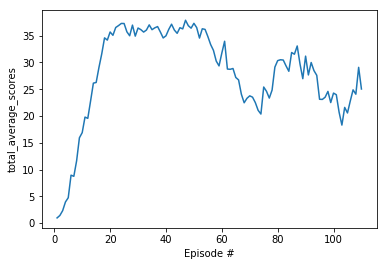

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

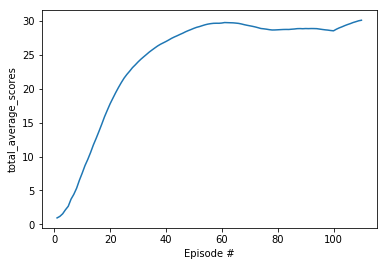

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs_deque)+1), meanRs_deque)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

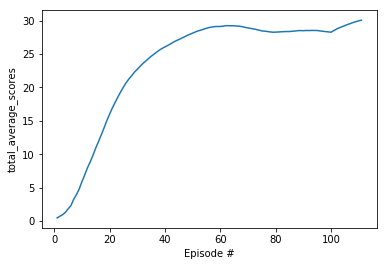

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

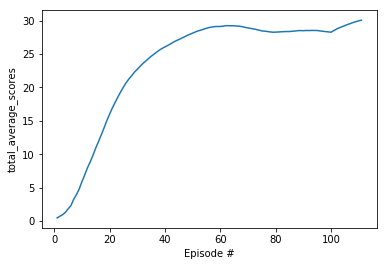

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

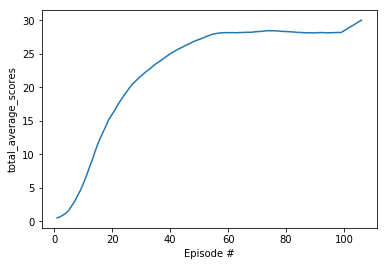

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

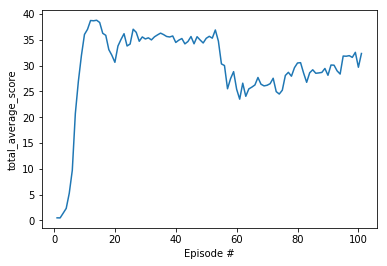

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

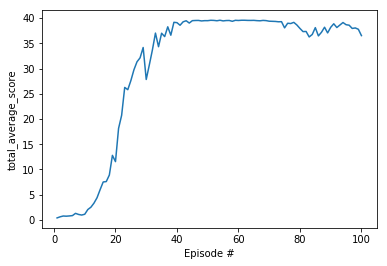

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

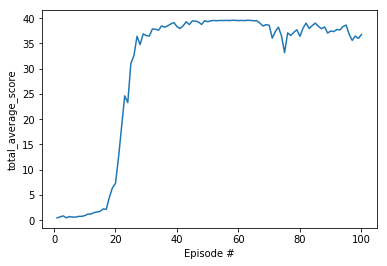

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

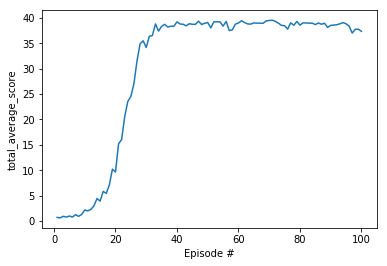

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

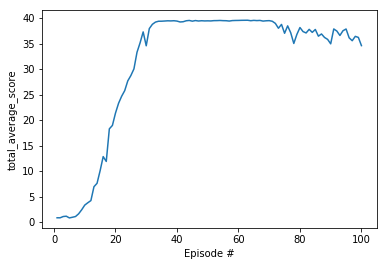

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

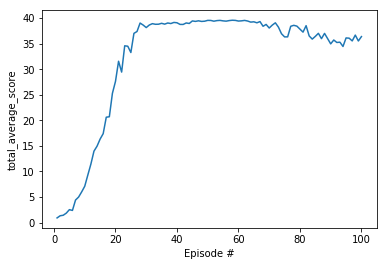

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

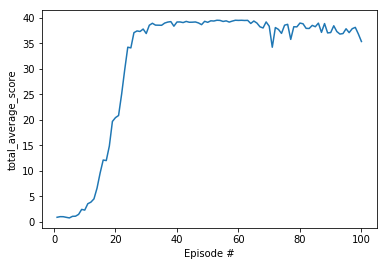

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('total_average_score')
plt.xlabel('Episode #')
plt.show()

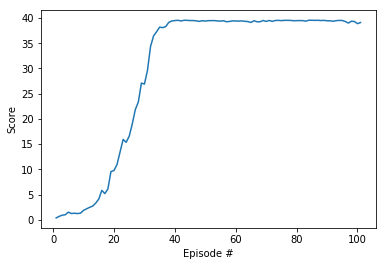

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

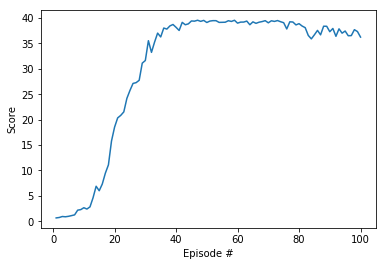

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

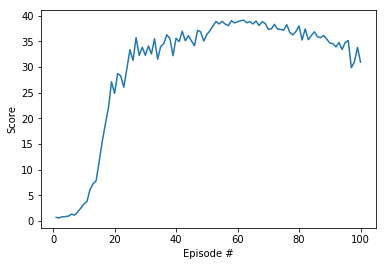

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

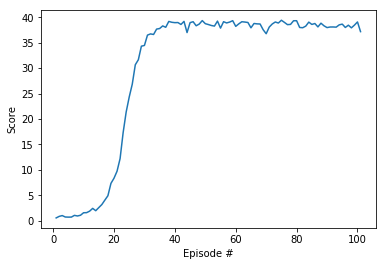

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

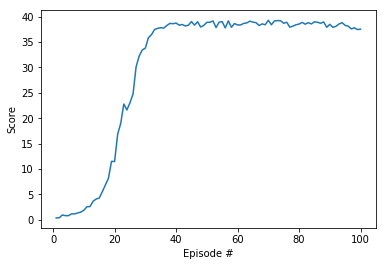

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

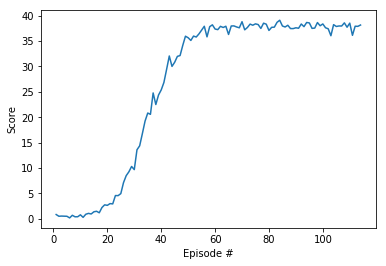

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

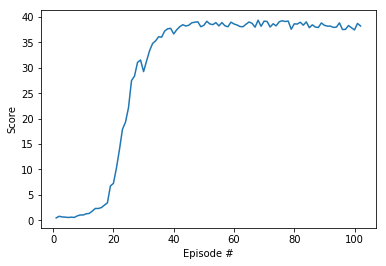

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [14]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-reacher-multiple.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-reacher-multiple.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (env)
S = env_info.vector_observations                  # get the current states (S) (for all agents)

Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for all agents)

while True:
    A = agent.act(S)                        # select actions (A) from loaded model agents
    
    env_info = env.step(A)[brain_name]           # send all actions (A) to the environment (env)
    S2 = env_info.vector_observations         # get next states (S2) (for all agents)
    rewards = env_info.rewards                         # get rewards (for all agents)
    dones = env_info.local_done                        # see if the episode is done/finished (terminal) for all agents
    
    Rs += rewards                         # update the total scores (Rs) (for all agents)
    S = S2                               # roll over current states (S) to next states (S2)
    
    if np.any(dones):                                  # exit loop if episode is done/finished for any of the agents among all of them
        break
        
print('Average of total scores: {}'.format(np.mean(Rs)))

Average of total scores: 19.826999556832014


When finished, you can close the environment.

In [6]:
env.close()